Import các thư viện cần dùng:

In [5]:
import numpy as np
from datascience import * 

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
from datetime import datetime

In [2]:
!pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl (11.1 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- -

Import tập dữ liệu

In [6]:
student_peformance_table = Table().read_table('student_performance_large_dataset.csv')
student_peformance_table.show(5)

Student_ID,Age,Gender,Study_Hours_per_Week,Preferred_Learning_Style,Online_Courses_Completed,Participation_in_Discussions,Assignment_Completion_Rate (%),Exam_Score (%),Attendance_Rate (%),Use_of_Educational_Tech,Self_Reported_Stress_Level,Time_Spent_on_Social_Media (hours/week),Sleep_Hours_per_Night,Final_Grade
S00001,18,Female,48,Kinesthetic,14,Yes,100,69,66,Yes,High,9,8,C
S00002,29,Female,30,Reading/Writing,20,No,71,40,57,Yes,Medium,28,8,D
S00003,20,Female,47,Kinesthetic,11,No,60,43,79,Yes,Low,13,7,D
S00004,23,Female,13,Auditory,0,Yes,63,70,60,Yes,Low,24,10,B
S00005,19,Female,24,Auditory,19,Yes,59,63,93,Yes,Medium,26,8,C


Phân tích các đặc điểm cơ bản của tập dữ liệu:

Bảng có 10000 hàng và 15 cột:

In [4]:
student_peformance_table.num_rows, student_peformance_table.num_columns

(10000, 15)

Tên của các cột:

In [5]:
student_peformance_table.labels

('Student_ID',
 'Age',
 'Gender',
 'Study_Hours_per_Week',
 'Preferred_Learning_Style',
 'Online_Courses_Completed',
 'Participation_in_Discussions',
 'Assignment_Completion_Rate (%)',
 'Exam_Score (%)',
 'Attendance_Rate (%)',
 'Use_of_Educational_Tech',
 'Self_Reported_Stress_Level',
 'Time_Spent_on_Social_Media (hours/week)',
 'Sleep_Hours_per_Night',
 'Final_Grade')

Kiểm tra xem có giá trị null không:

In [25]:
def has_missing(array):
  '''Hàm kiểm tra xem 1 mảng có chứa giá trị null không'''
  for item in array:
      if item is None:
          return True
  return False

is_missing = make_array()
for col in student_peformance_table.labels:
  is_missing = np.append(is_missing, has_missing(col))

is_missing

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.])

Vậy, không có giá trị null nào trong bảng.

## Phân bố 

# Câu hỏi nghiên cứu 1:
Học sinh dành hơn 25 giờ/tuần trên mạng xã hội (Time_Spent_on_Social_Media > 25) và ngủ dưới 7 giờ mỗi đêm (Sleep_Hours_per_Night < 7) có khả năng đạt điểm cuối kỳ dưới trung bình của tập dữ liệu không?

Đầu tiên, ta chọn những cột thông tin cần thiết:

In [31]:
table_for_q2 = student_peformance_table.select('Time_Spent_on_Social_Media (hours/week)', 'Sleep_Hours_per_Night', 'Exam_Score (%)')
table_for_q2

Time_Spent_on_Social_Media (hours/week),Sleep_Hours_per_Night,Exam_Score (%)
9,8,69
28,8,40
13,7,43
24,10,70
26,8,63
25,8,54
30,10,44
4,6,56
26,9,78
5,9,55


Ta sẽ lọc ra nhóm các học sinh dành hơn 25 giờ/tuần trên mạng xã hội (Time_Spent_on_Social_Media > 25) và ngủ dưới 7 giờ mỗi đêm (Sleep_Hours_per_Night < 7)

In [32]:
filtered_table = table_for_q2.where('Time_Spent_on_Social_Media (hours/week)', are.above(25)).where('Sleep_Hours_per_Night', are.below(7))
filtered_table

Time_Spent_on_Social_Media (hours/week),Sleep_Hours_per_Night,Exam_Score (%)
27,6,60
30,6,69
28,4,55
27,6,47
26,5,92
26,4,43
26,5,71
28,6,42
27,6,45
30,5,48


Ta sẽ tính điểm trung bình của nhóm học sinh này và của cả tập học sinh:


In [33]:
population_mean_grade = np.mean(table_for_q2.column('Exam_Score (%)'))
filtered_mean_grade = np.mean(filtered_table.column('Exam_Score (%)'))

population_mean_grade, filtered_mean_grade

(70.188900000000004, 70.392235609103082)

Như vậy, có vẻ như điểm trung bình của nhóm học sinh dành hơn 25 giờ/tuần trên mạng xã hội (Time_Spent_on_Social_Media > 25) và ngủ dưới 7 giờ mỗi đêm (Sleep_Hours_per_Night < 7) và tất cả học sinh trong tập dữ liệu là gần như ngang nhau, thậm chí nhóm này còn cao hơn một chút

Ta sẽ sử dụng Bootstrap để kiểm tra thống kê, thống kê được chọn sử dụng sẽ là điểm trung bình của sample có size bằng với số học sinh dành hơn 25 giờ/tuần trên mạng xã hội (Time_Spent_on_Social_Media > 25) và ngủ dưới 7 giờ mỗi đêm (Sleep_Hours_per_Night < 7)

In [42]:
n_bootstrap = 10000
bootstrap_means = make_array()

n_filtered = filtered_table.num_rows

# Lấy mẫu ngẫu nhiên và tính trung bình
for i in range(n_bootstrap):
    sample = student_peformance_table.sample(n_filtered)
    one_mean = np.mean(sample.column('Exam_Score (%)'))
    bootstrap_means = np.append(bootstrap_means, one_mean)
bootstrap_means

array([ 71.14323963,  69.41499331,  69.5394913 , ...,  70.16064257,
        70.81526104,  70.99464525])

Ta tạo histogram từ bootstrap_means

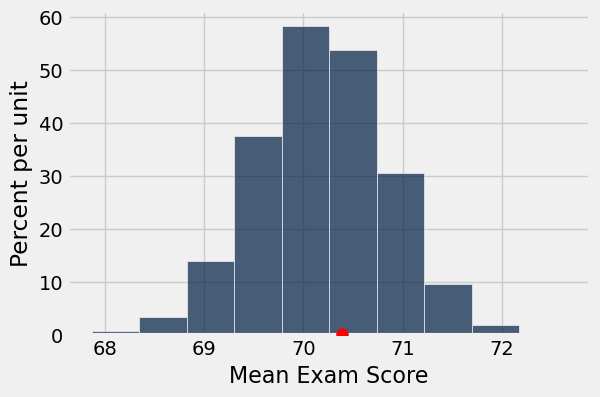

In [47]:
Table().with_column('Mean Exam Score', bootstrap_means).hist()
plt.scatter(filtered_mean_grade, 0.001, color='red', s=70, zorder=3)
plt.show()

Tính p-value:

In [49]:
p_value = np.count_nonzero(bootstrap_means <= filtered_mean_grade) / n_bootstrap
p_value

0.6234

Với mức cutoff 5%, ta kết luận rằng nhóm học sinh dành hơn 25 giờ/tuần trên mạng xã hội và ngủ dưới 7 giờ/đêm có điểm số trung bình giống với population.

# Câu hỏi nghiên cứu 2:
Học sinh không tham gia thảo luận (Participation_in_Discussions = No) và có tỷ lệ tham gia lớp học dưới 70% (Attendance_Rate < 70%) có xu hướng đạt điểm cuối kỳ D không?


Ta lấy từ dataset ra những cột cần thiết:

In [5]:
table_for_q1 = student_peformance_table.select('Participation_in_Discussions', 'Attendance_Rate (%)', 'Final_Grade')
table_for_q1

Participation_in_Discussions,Attendance_Rate (%),Final_Grade
Yes,66,C
No,57,D
No,79,D
Yes,60,B
Yes,93,C
Yes,80,D
Yes,66,D
Yes,76,C
No,70,B
No,100,C


Lọc ra những học sinh không tham gia thảo luận và có tỉ lệ tham gia lớp học dưới 70%:

In [7]:
filtered_table_1 = table_for_q1.where('Participation_in_Discussions', 'No').where('Attendance_Rate (%)', are.below(70))
filtered_table_1

Participation_in_Discussions,Attendance_Rate (%),Final_Grade
No,57,D
No,51,C
No,54,A
No,58,D
No,65,D
No,60,C
No,52,D
No,68,A
No,57,D
No,61,C


Tiếp thep, ta tính tỉ lệ phần trăm học sinh trong nhóm này bị điểm D:

In [10]:
percentage_D_filtered = np.count_nonzero(filtered_table_1.column('Final_Grade') == 'D') / filtered_table_1.num_rows * 100
percentage_D_filtered

25.94249201277955

Sau đó, ta tính tỉ lệ phần trăm học sinh bị điểm D trong cả tập dữ liệu rồi so sánh hai số liệu này với nhau:

In [11]:
percentage_D_population = np.count_nonzero(table_for_q1.column('Final_Grade') == 'D') / table_for_q1.num_rows * 100
percentage_D_population

24.27

Có thể thấy, hai chỉ số này không khác biệt nhau là mấy. Để thêm chắc chắn, ta tính thêm tỉ lệ phần trăm bị điểm D của nhóm học sinh có tham gia thảo luận và có tỉ lệ tham gia lớp học trên 70%

In [14]:
discussed_and_attended = table_for_q1.where('Participation_in_Discussions', 'Yes').where('Attendance_Rate (%)', are.above(70))
discussed_and_attended

Participation_in_Discussions,Attendance_Rate (%),Final_Grade
Yes,93,C
Yes,80,D
Yes,76,C
Yes,74,C
Yes,76,A
Yes,93,A
Yes,90,A
Yes,82,B
Yes,73,B
Yes,100,A


In [15]:
percentage_D_discussed_and_attended = np.count_nonzero(discussed_and_attended.column('Final_Grade') == 'D') / discussed_and_attended.num_rows * 100
percentage_D_discussed_and_attended

25.106624964458348

Ta có thể thấy, 3 nhóm đều có tỉ lệ điểm D ngang nhau. Nhóm không tham gia thảo luận và có tỉ lệ tham gia lớp học dưới 70% chỉ có tỉ lệ bị D cao hơn một chút so với nhóm có tham gia thảo luận và tham gia lớp học trên 70%.

Như vậy, ta không thể kết luận học sinh không tham gia thảo luận (Participation_in_Discussions = No) và có tỷ lệ tham gia lớp học dưới 70% (Attendance_Rate < 70%) không có xu hướng đạt điểm D.